**Student Name**: Varun Venkatesh

**Student Roll No**: 21F1000743

**DEADLINE: 30th July, 2023**

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import *

np.random.seed(3939)
random.seed(3939)

alphas = [0.001, 0.01, 0.1, 1.0]
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
temperatures =  [0.01, 0.1, 1, 2]
void_temperature = None
void_epsilon = None
num_episodes = 1500
num_agents = 200
max_steps = 100

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

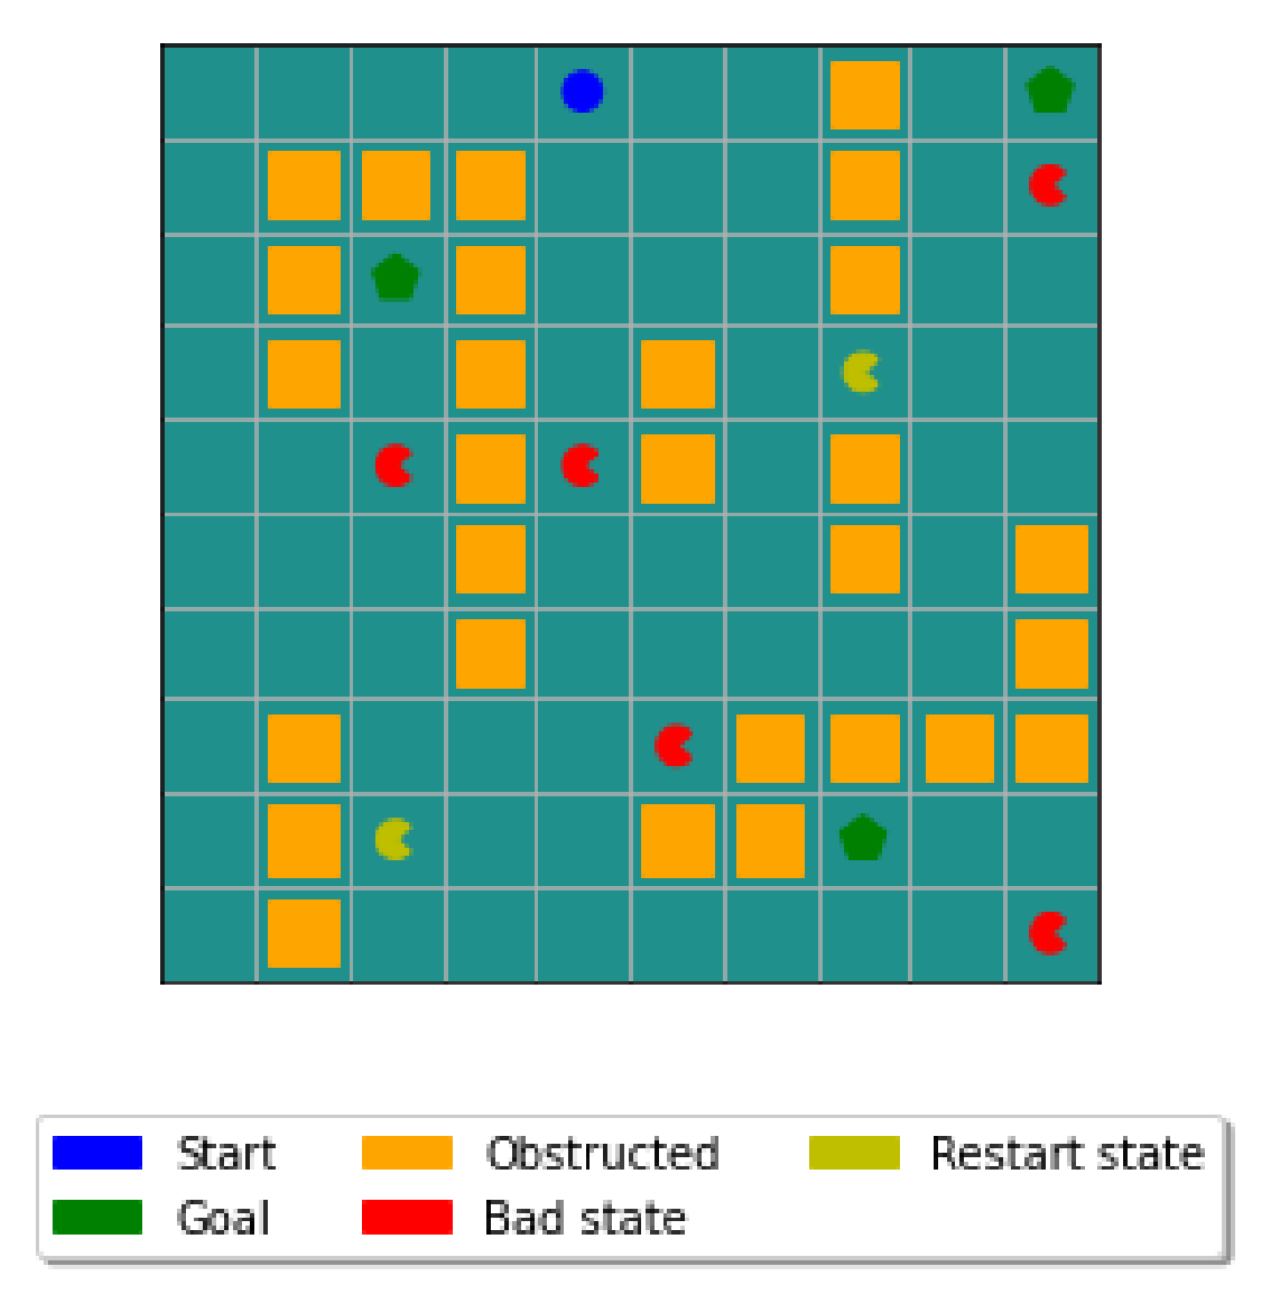

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

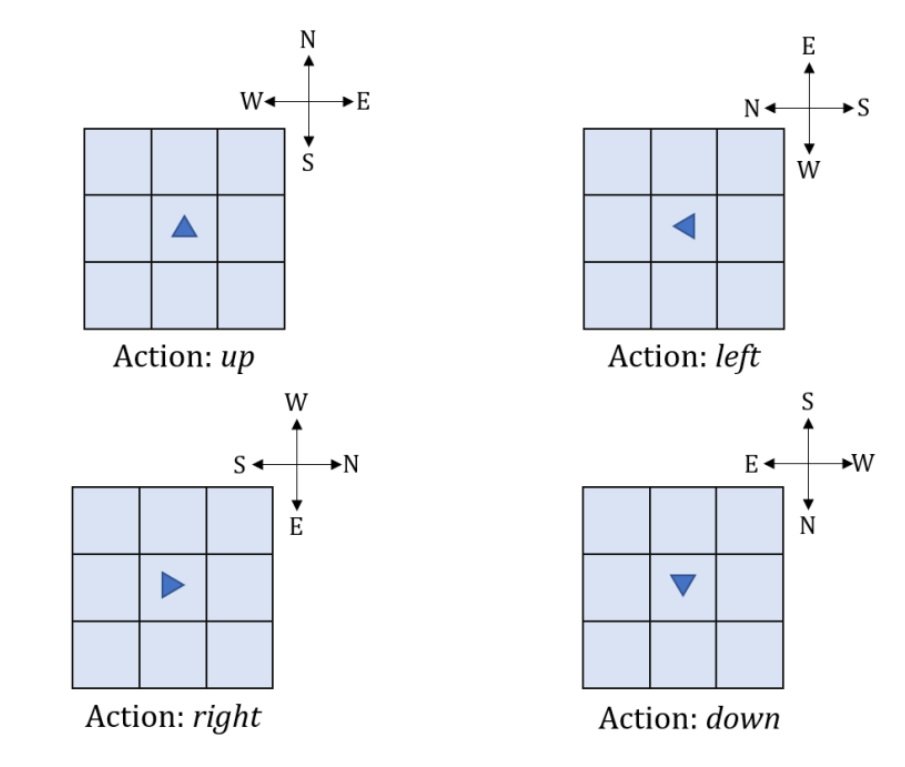

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


In [ ]:
row_col_to_seq(np.array([[0,1]]), 10)

array([1])

In [ ]:
np.array([[0,1]])[:,0]

array([0])

## Environment instantiation

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
# env.visualize_gridworld()

## List environment variables

In [ ]:
# print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
# print("Number of states", env.num_states)
# print("start state", env.start_state_seq)
# print("goal state(s)", env.goal_states_seq)

The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

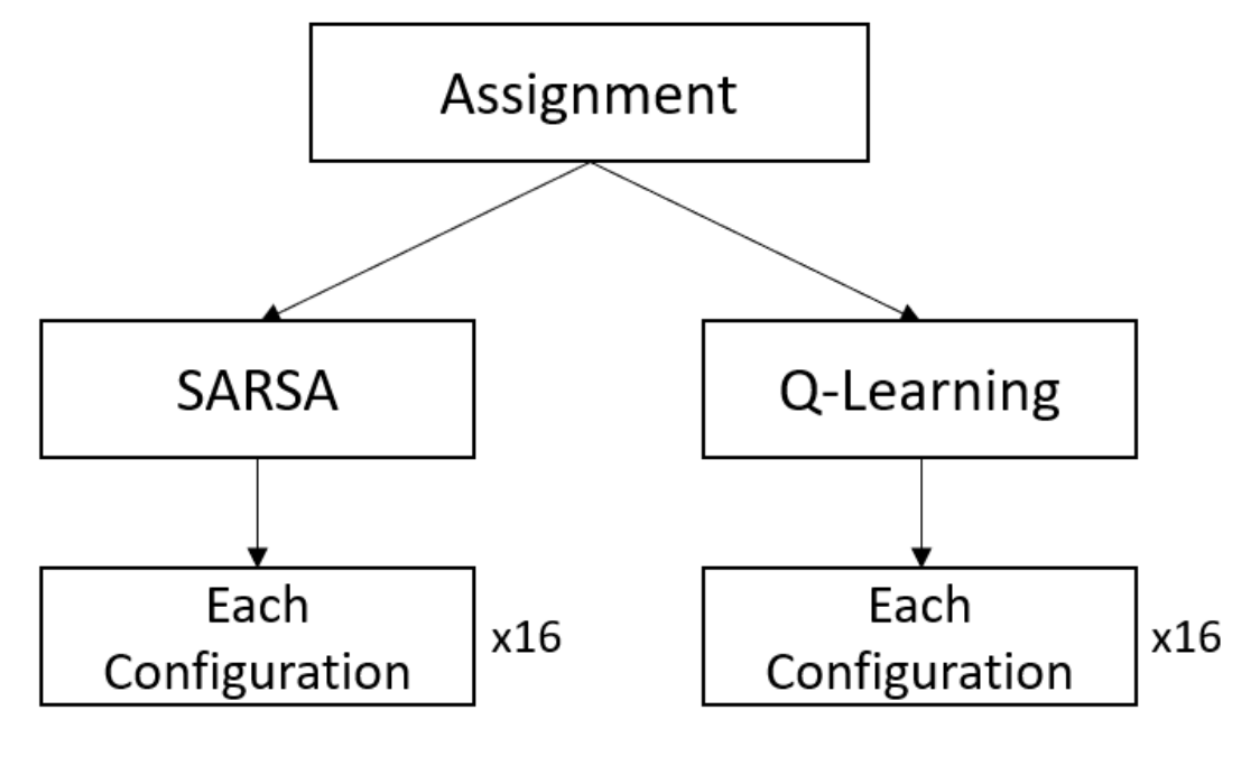

In [ ]:
class SARSAExp:
  def __init__(self, p, wind, start_state, strat, **kwargs):

    self.rewards = {}
    self.steps = {}
    self.configs = {}
    self.state_visits = {}
    self.Q = {}

    self.p = p
    self.wind = wind
    self.start_state = np.array([start_state])

    self.strat = strat
    self.gw = GridWorld(num_rows=num_rows,
                        num_cols=num_cols,
                        start_state=self.start_state,
                        goal_states=goal_states,
                        wind = self.wind)

    self.gw.add_obstructions(obstructed_states=obstructions,
                             bad_states=bad_states,
                             restart_states=restart_states)

    self.gw.add_rewards(step_reward=-1,
                        goal_reward=10,
                        bad_state_reward=-6,
                        restart_state_reward=-100)

    self.gw.add_transition_probability(p_good_transition= self.p,
                                       bias=0.5)

    self.env = self.gw.create_gridworld()


In [ ]:
class QLearning:
  def __init__(self, p, wind, start_state, strat, **kwargs):
    self.rewards = {}
    self.steps = {}
    self.configs = {}
    self.state_visits = {}
    self.Q = {}

    self.p = p
    self.wind = wind
    self.start_state = np.array([start_state])

    self.strat = strat
    self.gw = GridWorld(num_rows=num_rows,
                        num_cols=num_cols,
                        start_state=self.start_state,
                        goal_states=goal_states,
                        wind = self.wind)

    self.gw.add_obstructions(obstructed_states=obstructions,
                             bad_states=bad_states,
                             restart_states=restart_states)

    self.gw.add_rewards(step_reward=-1,
                        goal_reward=10,
                        bad_state_reward=-6,
                        restart_state_reward=-100)

    self.gw.add_transition_probability(p_good_transition= self.p,
                                       bias=0.5)

    self.env = self.gw.create_gridworld()


def run_Qlearning(params):
  exp, alpha, gamma, epsilon, temperature, num_episodes, max_steps, num_agents = params
  config_name = f"Method_{exp.strat}_Alpha_{alpha}_Gamma_{gamma}_Epsilon_{epsilon}_Temp_{temperature}"
  config = {'num_episodes': num_episodes, 'max_steps': max_steps,
                                  'num_agents': num_agents, 'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon}


  total_rewards = np.zeros((num_agents, num_episodes))
  total_steps = np.zeros((num_agents, num_episodes))
  state_visits = np.zeros(exp.env.num_states)
  Q = np.zeros((num_agents, exp.env.num_states, exp.env.num_actions))

  for agent in range(num_agents):
    for episode in range(num_episodes):
        state = exp.env.reset()

        for step in range(max_steps):
            state_visits[state] += 1
            total_steps[agent, episode] += 1

            action = select_action(Q[agent, :, :], state, exp.strat, epsilon, temperature)
            next_state, reward = exp.env.step(state, action)
            max_next_action_value = np.max(Q[agent, next_state, :])
            target = reward + gamma * max_next_action_value
            error = target - Q[agent, state, action]
            Q[agent, state, action] += alpha * error
            total_rewards[agent, episode] += reward
            state = next_state

            if state in exp.env.goal_states_seq:
              state_visits[state] += 1
              break

  avg_rewards_per_episode = np.mean(total_rewards, axis=0)
  avg_steps_per_episode = np.mean(total_steps, axis=0)

  return config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode


In [ ]:
from scipy import special

def epsilon_greedy(Q, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(Q.shape[1])  # Choose a random action
        else:
            return np.argmax(Q[state, :])  # Choose the action with the highest Q value

# def softmax(Q, state, temperature=0.1):
#         logits = Q[state, :] / temperature
#         exp_logits = np.exp(logits - np.max(logits))
#         probs = exp_logits / np.sum(exp_logits)
#         action = np.random.choice(len(probs), p=probs)
#         return action

def select_action(Q, state, method='eps', epsilon=0.1, temperature=0.1):
        if method == 'eps':
            return epsilon_greedy(Q, state, epsilon)
        else:
            probs = special.softmax(Q[state, :]/temperature)
            action = np.random.choice(len(probs), p=probs)
            return action


def run_experiment(params):

    exp, alpha, gamma, epsilon, temperature, num_episodes, max_steps, num_agents = params

    config_name = f"Method_{exp.strat}_Alpha_{alpha}_Gamma_{gamma}_Epsilon_{epsilon}_Temp_{temperature}"
    config = {'num_episodes': num_episodes, 'max_steps': max_steps,
                                  'num_agents': num_agents, 'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon}


    total_rewards = np.zeros((num_agents, num_episodes))
    total_steps = np.zeros((num_agents, num_episodes))

    state_visits = np.zeros(exp.env.num_states)
    # Q = -1*np.random.rand(num_agents, exp.env.num_states, exp.env.num_actions)
    Q = np.zeros((num_agents, exp.env.num_states, exp.env.num_actions))

    # for bad_state in exp.env.bad_states:
    #   Q[:,row_col_to_seq(np.array([bad_state]), 10)[0],:] = -15

    # for obs_state in exp.env.obs_states:
    #   Q[:,row_col_to_seq(np.array([obs_state]), 10)[0],:] = -15

    # for restart_state in exp.env.restart_states:
    #   Q[:,row_col_to_seq(np.array([restart_state]), 10)[0],:] = -15


    # Q[:, exp.env.goal_states_seq, :] = 0


    for agent in range(num_agents):
            for episode in range(num_episodes):
                state = exp.env.reset()
                state_visits[state] += 1
                action = select_action(Q[agent, :, :], state, exp.strat, epsilon, temperature)

                for step in range(max_steps):
                    total_steps[agent, episode] += 1
                    next_state, reward = exp.env.step(state, action)
                    next_action = select_action(Q[agent, :, :], next_state, exp.strat , epsilon, temperature)
                    Q[agent, state, action] += alpha * (reward + gamma * Q[agent, next_state, next_action] - Q[agent, state, action])
                    total_rewards[agent, episode] += reward

                    state, action = next_state, next_action
                    state_visits[state] += 1

                    if state in exp.env.goal_states_seq:
                        break

    avg_rewards_per_episode = np.mean(total_rewards, axis=0)
    avg_steps_per_episode = np.mean(total_steps, axis=0)

    return config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode
    # self.rewards[config_name] = avg_rewards_per_episode
    # self.steps[config_name] = avg_steps_per_episode

In [ ]:
class SARSAExpHelper:

  def __init__(self, exp):
    self.exp = exp

  def best_config(self):
    max_reward = -np.inf
    max_config = None

    for c, r in self.exp.rewards.items():
      total_rewards = np.sum(r)
      if total_rewards > max_reward:
        max_config = c
        max_reward = total_rewards
    return max_config


  def plot_results(self):
          fig = go.Figure()
          for c,r in self.exp.rewards.items():
              fig.add_trace(go.Scatter(x=np.arange(1, len(r) + 1), y=r, mode='lines', name=c))

          fig.update_layout(title='Average Rewards per Episode',
                            xaxis_title='Episode',
                            yaxis_title='Average Reward')
          fig.show()


  def plot_best_curve(self):
    fig = go.Figure()
    max_config = self.best_config()
    best_rewards = self.exp.rewards[max_config]
    fig.add_trace(go.Scatter(x=np.arange(1, len(best_rewards) + 1), y=best_rewards, mode='lines', name=max_config))
    fig.update_layout(title=f'Average Rewards per Episode {max_config}',
                          xaxis_title='Episode',
                          yaxis_title='Average Reward')
    fig.show()

  def plot_best_steps(self):
    max_config = self.best_config()
    best_steps = self.exp.steps[max_config]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(1, len(best_steps) + 1), y=best_steps, mode='lines', name=max_config))
    fig.update_layout(title=f'Average steps per episode {max_config}',
                          xaxis_title='Episode',
                          yaxis_title='Average Steps')
    fig.show()

  def plot_state_visit_heatmap(self):
    max_config = self.best_config()
    fig = px.imshow(self.exp.state_visits[max_config].reshape(10,10)/self.exp.Q[max_config].shape[0], text_auto=True, title='Average number of times each state was visited')
    fig.show()

  def plot_policy_q_heatmap(self):
    max_config = self.best_config()
    qsa = np.mean(self.exp.Q[max_config], axis=0)
    Q = np.max(qsa, axis=1).reshape(10,10)
    R = np.argmax(qsa, axis=1).reshape(10,10)

    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(Q, cmap='viridis', interpolation='nearest')

    for i in range(len(Q)):
      for j in range(len(Q[0])):
        if Q[i,j] != -15:
          plt.text(j, i, f'{Q[i, j]:.2f}', ha='center', va='center', color='white')

    for i in range(len(R)):
      for j in range(len(R[0])):
        if Q[i,j] not in [-15, 0]:
          if R[i, j] == 0:
              plt.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2)
          elif R[i, j] == 1:
              plt.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2)
          elif R[i, j] == 2:
              plt.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2)
          elif R[i, j] == 3:
              plt.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2)

    plt.colorbar(heatmap)
    plt.title('Heatmap of the Optimal Policy and State-Action value')
    plt.show()


In [82]:
class QLearningHelper(SARSAExpHelper):
  def __init__(self, exp):
    super().__init__(exp)


In [ ]:
def hyperparam_generator(exp, epsilon=True):
  params = []
  if epsilon:
    for alpha in alphas:
      for gamma in gammas:
        for epsilon in epsilons:
          params.append((exp, alpha, gamma, epsilon, void_temperature, num_episodes, max_steps, num_agents))
  else:
    for alpha in alphas:
      for gamma in gammas:
        for temp in temperatures:
          params.append((exp, alpha, gamma, void_epsilon, temp, num_episodes, max_steps, num_agents))

  return params

In [ ]:
def param_generator(code, sarsa):
  wind = [False, True]
  start_state = [[0,4], [3,6]]
  strat = ['eps', 'softmax']
  p = [1, 0.7]

  if sarsa:
    params = {'p': 1,
           'wind': wind[int(code[0])],
           'start_state': start_state[int(code[1])],
           'strat': strat[int(code[2])]
    }
  else:
    params = {
        'p': p[int(code[0])],
        'wind': False,
        'start_state': start_state[int(code[1])],
        'strat': strat[int(code[2])]
    }

  return params

## Configurations [64 Marks]

## SARSA

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

### (0) Configuration id SARSA_000


#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# @title SARSA: (0, 0, 0) = (False, [0,4], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

params_000 = param_generator('000', True)
print(f'Evaluating config {params_000} \n')
sarsa_000 = SARSAExp(**params_000)


hyperparams_000 = hyperparam_generator(sarsa_000, epsilon=True)


with Pool(processes=8) as p:
  results_000 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_000):
      results_000.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_000:
      sarsa_000.configs[config_name] = config
      sarsa_000.state_visits[config_name] = state_visits
      sarsa_000.Q[config_name] = Q
      sarsa_000.rewards[config_name] = avg_rewards_per_episode
      sarsa_000.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': False, 'start_state': [0, 4], 'strat': 'eps'} 



100%|██████████| 64/64 [1:32:46<00:00, 86.98s/it]


In [ ]:
sarsa_000helper = SARSAExpHelper(sarsa_000)

print('\n')
print(sarsa_000helper.best_config())



Method_eps_Alpha_1.0_Gamma_1.0_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_000helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_000helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_000helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

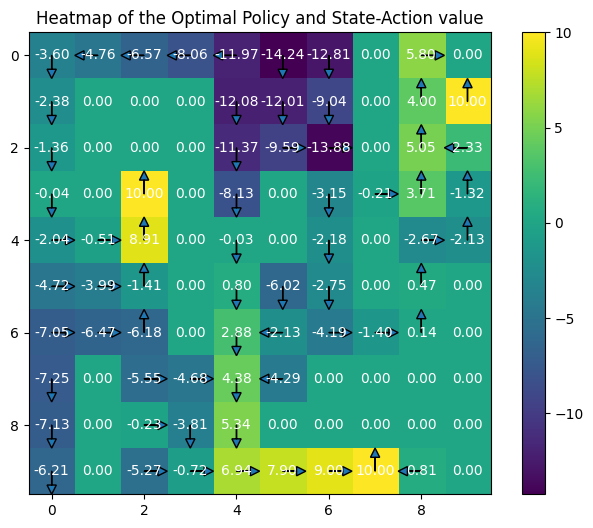

In [ ]:
sarsa_000helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

For question 2, I will be comparing each config with the previous configs henceforth hence there is a combined answer for the 2 questions as this config is treated as a base case.

The Best hyperparameters for this config is as follows:
- α = 1.0: all new information is incorporated into the estimates and therefore newer information have a greater impact on the Q-values i.e. the agent quickly adapts its policy based on the most recent experiences. Since the agent gives full weight to most recent experiences, it might overreact to outliers.  Since $p=1$, the rewards and transitions are stationary and therefore α=1.0 makes sense as it could lead to a faster learning

- γ = 1.0: signifies that the agent places equal importance on immediate and future rewards i.e. the agent considers future rewards to be as important as immediate rewards and places full emphasis on maximizing cumulative rewards over the entire trajectory. On our optimal policy to reach (2,2) and (7,8), we can see that by prioritizing actions that lead to high cumulative returns in the distant future, even if they incur immediate costs, the agent is not afraid to enter bad states if it leads to reaching the goal state with higher cumulative reward.

- ϵ = 0.001: the agent predominantly exploits the best known actions based on the greedy policy. This would again make sense given the stationarity of transitions and rewards. Over a large number of agents and episodes, we should not get stuck in a local optima.

The initial oscillations for the rewards vs episodes curve and the steps vs episodes curve could be explained by epsilon-greedy action selection. As all values are initialized to 0, once an action is selected and its value is updated with a negative value, even if it is the optimal action, the algorithm will choose one of the other other actions with a very high probability since it is initialized to 0. Thus the initial oscillations could be explained this way. I confirmed this when I ran a smaller experiment where I initialised all the Q values with a high negative value and thus the curve was much smoother. However I felt this method encouraged more exploration in the beginning which is well suited for a stationary problem.





### (1) Configuration id SARSA_001


#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# @title SARSA: (0, 0, 1) = (False, [0,4], softmax)
np.random.seed(3939)
random.seed(3939)

params_001 = param_generator('001', True)
print(f'Evaluating config {params_001} \n')
sarsa_001 = SARSAExp(**params_001)

hyperparams_001 = hyperparam_generator(sarsa_001, epsilon=False)


with Pool(processes=8) as p:
  results_001 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_001):
      results_001.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_001:
      sarsa_001.configs[config_name] = config
      sarsa_001.state_visits[config_name] = state_visits
      sarsa_001.Q[config_name] = Q
      sarsa_001.rewards[config_name] = avg_rewards_per_episode
      sarsa_001.steps[config_name] = avg_steps_per_episode

sarsa_001helper = SARSAExpHelper(sarsa_001)
print(sarsa_001helper.best_config())

Evaluating config {'p': 1, 'wind': False, 'start_state': [0, 4], 'strat': 'softmax'} 



100%|██████████| 64/64 [4:02:41<00:00, 227.52s/it]

Method_softmax_Alpha_1.0_Gamma_1.0_Epsilon_None_Temp_1


In [ ]:
sarsa_001helper = SARSAExpHelper(sarsa_001)

print('\n')
print(sarsa_001helper.best_config())



Method_softmax_Alpha_1.0_Gamma_1.0_Epsilon_None_Temp_1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_001helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_001helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_001helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

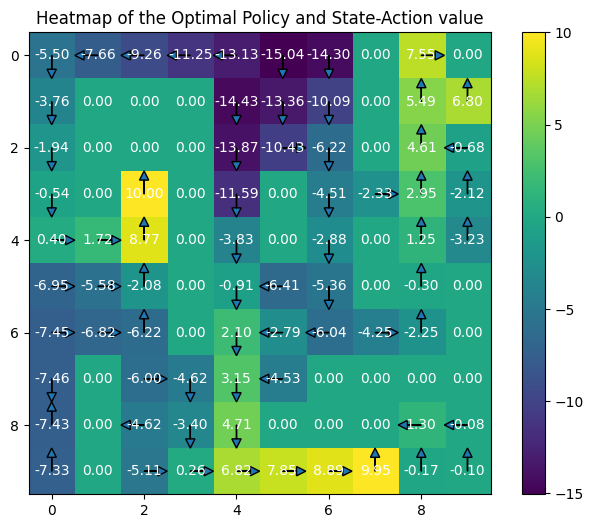

In [ ]:
sarsa_001helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Similar to the previous problem, this config also learnt a similar policy converging to the goal state (2,2). However the the Q values for the initial state for the epsilon-greedy method is sligtly lower.

The best hyperparameter combination for this config is

- α = 1.0: all new information is incorporated into the estimates and therefore newer information have a greater impact on the Q-values i.e. the agent quickly adapts its policy based on the most recent experiences. Since the agent gives full weight to most recent experiences, it might overreact to outliers.  Since $p=1$, the rewards and transitions are stationary and therefore α=1.0 makes sense as it could lead to a faster learning.

- γ = 1.0: signifies that the agent places equal importance on immediate and future rewards i.e. the agent considers future rewards to be as important as immediate rewards and places full emphasis on maximizing cumulative rewards over the entire trajectory.

- τ = 1: encourages a more diversified exploration potentially leading to discovering more diverse and potentially better policies.


On our optimal policy to reach (2,2) and (7,8), we can see that by prioritizing actions that lead to high cumulative returns in the distant future, even if they incur immediate costs, the agent is not afraid to enter bad states if it leads to reaching the goal state with higher cumulative reward.


2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The main difference between this config and the previous one is that softmax action selection was chosen instead of epsilon-greedy. Here are the main differences:

- There isn't much oscillation in the rewards vs episodes curve and the steps vs episode curve. This is because Epsilon-greedy does not differentiate much among actions based on their values; it favors the best action heavily. In contrast, softmax considers relative differences in action values to assign probabilities. Softmax provides a smoother exploration profile due to the continuous probability distribution over actions, whereas epsilon-greedy can lead to abrupt shifts between exploitation and exploration.

- After 50 episodes, the average reward per episode with Epsilon-Greedy was approximately -12, but it was approximately -8 for softmax showing that softmax converged faster.

- Similarly after 50 episodes, the average number of steps taken by the agent was approx 16 with softmax and approx 18 with epsilon-greedy indicating better convergence when softmax was used.

- From the state-visit heatmaps, we can see that episilon-greedy reached the goal state (2,2) 421 times, (9,0) 716 times and (7,8) 347 times. Although the visits to goal state (9,0) was visited much higher, the optimal policy converges to (2,2) indicating that perhaps it converged to this path much later during the learning process. For softmax however, there is pretty much an even split between reaching the goal state (2,2) and (7,8) with the goal state (9,0) getting much fewer visits.

### (3) Configuration id SARSA_011


#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# @title SARSA: (0, 1 , 1) = (False, [3,6], softmax)
np.random.seed(3939)
random.seed(3939)

params_011 = param_generator('011', True)
print(f'Evaluating config {params_011} \n')
sarsa_011 = SARSAExp(**params_011)

hyperparams_011 = hyperparam_generator(sarsa_011, epsilon=False)


with Pool(processes=8) as p:
  results_011 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_011):
      results_011.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_011:
      sarsa_011.configs[config_name] = config
      sarsa_011.state_visits[config_name] = state_visits
      sarsa_011.Q[config_name] = Q
      sarsa_011.rewards[config_name] = avg_rewards_per_episode
      sarsa_011.steps[config_name] = avg_steps_per_episode

sarsa_011helper = SARSAExpHelper(sarsa_011)
print(sarsa_011helper.best_config())

Evaluating config {'p': 1, 'wind': False, 'start_state': [3, 6], 'strat': 'softmax'} 



100%|██████████| 64/64 [3:44:05<00:00, 210.09s/it]

Method_softmax_Alpha_1.0_Gamma_0.8_Epsilon_None_Temp_0.1


In [ ]:
sarsa_011helper = SARSAExpHelper(sarsa_011)

print('\n')
print(sarsa_011helper.best_config())



Method_softmax_Alpha_1.0_Gamma_0.8_Epsilon_None_Temp_0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_011helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_011helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_011helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

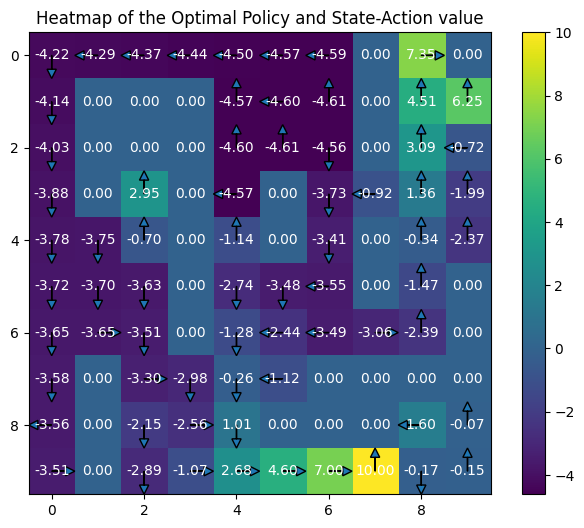

In [ ]:
sarsa_011helper.plot_policy_q_heatmap()

In [141]:
sarsa_011.env.visualize_gridworld()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.


The best hyperparameter combination for this config is:

- α = 1.0 : Similar to the previous two configs, the best hyperparameter    
configuration also has α=1.0. However unlike the previous two combinations the γ, and τ are different.


- γ = 0.8: the agent slightly reduces the emphasis on future rewards. The agent becomes more myopic, focusing more on immediate rewards.


- τ = 0.1: the lower temperature value leads to more deterministic action selection, where the agent predominantly selects actions with higher Q-values. This reduces exploration and tends towards exploitation of the best-known actions. This is evident in the state-visit heatmap as well as primarly the trajectory to goal state (7,8) is visited. (9,0) is visited much lower and the goal state (4,0) is visited even fewer times.


The policy learnt by the agent is optimal following a path from the start state to goal state (9,0) avoiding the bad state at (9,1) and the restart state at (7,3).


2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The difference between this config and the previous config is the start state and therefore my focus would be on that.

- For config 001, two of the three goal states were visited pretty evenly with each accounting for about 40% of the trajectories. However for this config, a single goal state accounts for over 70% of the trajectories. This is possibly caused due to the difference in τ values. τ=1.0 encourages exploration whereas τ=0.1 encourages exploitation.

- The stark difference in the state-visit heatmaps could also be explained by the fact that for the start state (4,0), all three goal states can be reached accumulating equal undiscounted return. This is however not the case for start state (6,3). Two of them can be reached for an equal return whereas for (2,2) the return is lower.

- Hence the combination of τ=0.1 and only two goal states being equidistant from the (3,6) is likely the reason why one particular trajectory was visited for most of the time by the agent.

- Furthemore when we compare the rewards vs episodes curve and the steps vs episodes curve for config 001 and 011, we can see that by the 50th episode config 011 takes approximately 12 steps which is the optimal number of steps and similarly by the 50th episode config 011 has converged to it optimal reward.

### (2) Configuration id SARSA_010


#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# @title SARSA: (0, 1, 0) = (False, [3,6], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

params_010 = param_generator('010', True)
print(f'Evaluating config {params_010} \n')
sarsa_010 = SARSAExp(**params_010)

hyperparams_010 = hyperparam_generator(sarsa_010, epsilon=True)


with Pool(processes=8) as p:
  results_010 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_010):
      results_010.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_010:
      sarsa_010.configs[config_name] = config
      sarsa_010.state_visits[config_name] = state_visits
      sarsa_010.Q[config_name] = Q
      sarsa_010.rewards[config_name] = avg_rewards_per_episode
      sarsa_010.steps[config_name] = avg_steps_per_episode

sarsa_010helper = SARSAExpHelper(sarsa_010)
print(sarsa_010helper.best_config())

Evaluating config {'p': 1, 'wind': False, 'start_state': [3, 6], 'strat': 'eps'} 



100%|██████████| 64/64 [1:25:46<00:00, 80.41s/it]

Method_eps_Alpha_1.0_Gamma_0.7_Epsilon_0.001_Temp_None


In [ ]:
sarsa_010helper = SARSAExpHelper(sarsa_010)

print('\n')
print(sarsa_010helper.best_config())



Method_eps_Alpha_1.0_Gamma_0.7_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_010helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_010helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_010helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

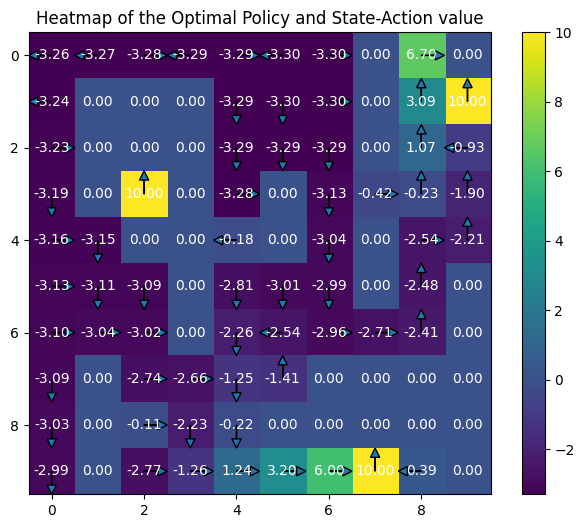

In [ ]:
sarsa_010helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.


The Best hyperparameters for this config is as follows:
- α = 1.0: Similar to all configurations thus far, with α=1.0 the agent prefers to adapt quickly to new information and update Q-values significantly based on recent experiences.


- γ = 0.7: Similar to config 011, with γ=0.7 the agent reduces the emphasis on future rewards. The agent becomes more myopic, focusing more on immediate rewards prioritizing short-term gains.

- ϵ = 0.001: Similar to config 000, with ϵ=0.001 the agent mostly chooses actions that it currently believes are the best, reducing exploration.

The policy learnt by the agent is suboptimal. At state (8,4) it chooses to go right instead of up.

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

For this config, I would be comparing the difference between this config and config 000 and 011.

- The difference between this config and config 000 is the start state. With the change in start state, the agent has preferred a lower γ which means it doesn't emphasize long term rewards as much as config 000.

- However when we compare the state-visit heatmap, config 000 with start state (4,0) visits goal state (9,0) about 50% of the trajectories and about 25% each for the remaining two goal states. When the start is (6,3), the agent clearly visits one goal state about 65% of time time and one of the other goal states 35% of the time. Across 1500 episodes and 200 agents, on average the third goal state was visited only once. This is also because ϵ=0.001 and the third goal state at (2,2) clearly has a much lower return than the other two goal states.

The difference between this config and 011 is epsilon-greedy and softmax.

- There isn't much oscillation in the rewards vs episodes curve and the steps vs episode curve for config 011. This is because Epsilon-greedy does not differentiate much among actions based on their values; it favors the best action heavily. In contrast, softmax considers relative differences in action values to assign probabilities. Softmax provides a smoother exploration profile due to the continuous probability distribution over actions, whereas epsilon-greedy can lead to abrupt shifts between exploitation and exploration.

- When softmax is used in config 011, by episode 50 the average reward is -2 whereas for epsilon-greedy it is approximately -6. Even after 1500 episodes, the average reward from epsilon-greedy is higher than that of softmax. This is likely because the policy learnt by epsilon-greedy is suboptimal due to the chosen action at state (8,4)


### (6) Configuration id SARSA_110


#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# @title SARSA: (1, 1, 0) = (True, [3,6], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

params_110 = param_generator('110', True)
print(f'Evaluating config {params_110} \n')
sarsa_110 = SARSAExp(**params_110)


hyperparams_110 = hyperparam_generator(sarsa_110, epsilon=True)


with Pool(processes=8) as p:
  results_110 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_110):
      results_110.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_110:
      sarsa_110.configs[config_name] = config
      sarsa_110.state_visits[config_name] = state_visits
      sarsa_110.Q[config_name] = Q
      sarsa_110.rewards[config_name] = avg_rewards_per_episode
      sarsa_110.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': True, 'start_state': [3, 6], 'strat': 'eps'} 



100%|██████████| 64/64 [1:29:15<00:00, 83.68s/it]


In [ ]:
sarsa_110helper = SARSAExpHelper(sarsa_110)

print('\n')
print(sarsa_110helper.best_config())



Method_eps_Alpha_0.1_Gamma_1.0_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_110helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_110helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_110helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

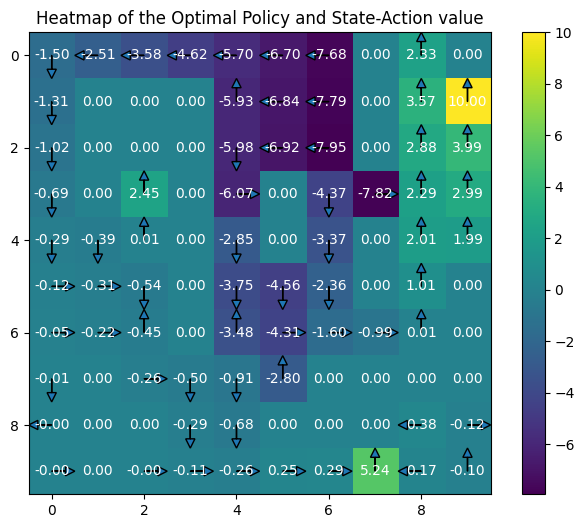

In [ ]:
sarsa_110helper.plot_policy_q_heatmap()

In [151]:
np.mean(sarsa_110.Q['Method_eps_Alpha_0.1_Gamma_1.0_Epsilon_0.001_Temp_None'][:,8,:], axis=0)

array([2.33115724, 0.18657319, 0.86936125, 0.39354692])

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.


The Best hyperparameters for this config is as follows:
- α = 0.1 : the agent is cautious and tends to rely more on past experiences, updating Q-values slowly. A smaller α encourages more exploration as it places less weight on new information, allowing the agent to consider past experiences more.

- γ = 1.0: signifies that the agent places equal importance on immediate and future rewards i.e. the agent considers future rewards to be as important as immediate rewards and places full emphasis on maximizing cumulative rewards over the entire trajectory.

- ϵ = 0.001: Similar to config 010, with ϵ=0.001 the agent mostly chooses actions that it currently believes are the best, reducing exploration.

The agent learns more or less the optimal policy preferring the goal state (9,0). The interesting part is action chose for state (8,0) wherein the Q value for action up is more than that of right.

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The major difference in this config vs config 010 is the this one has wind. Here are the major changes:

- The agent took a long time to converge. This is evident from both the rewards vs episodes curve and the steps vs episodes curve. It took almost 150 episodes before it converged to its optimal reward and steps which is 3 times what it took for previous configs so far.

- One particular trajectory was heavily explored. Over 90% of the trajectories ended up in Goal state (9,0). It is no surprise that that would be the case since the wind pushes the agent to the right and thus it is more likely that the agent lands in a state where the goal state (9,0) is more favourable than other goal states.

- We also see that the the agent followed a trajectory close to the right edge of the gridworld. States (9,1) and (9,2) were visited almost equally as often as the goal state (9,0) despite state (9,1) being a bad state.

- The choice of action up in the state (8,0) could also be explained by the wind. On choosing action up, the agent end ups in the goal state (9,0) approx 40% of the time. Thus it is possible that the wind caused the agent to end up in the goal states in the beginning of the training and with ϵ=0.001, this action was then preferred over 99% of the time.



### (7) Configuration id SARSA_111


#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# @title SARSA: (1, 1, 1) = (True, [3,6], softmax)
np.random.seed(3939)
random.seed(3939)

params_111 = param_generator('111', True)
print(f'Evaluating config {params_111} \n')
sarsa_111 = SARSAExp(**params_111)


hyperparams_111 = hyperparam_generator(sarsa_111, epsilon=False)


with Pool(processes=8) as p:
  results_111 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_111):
      results_111.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_111:
      sarsa_111.configs[config_name] = config
      sarsa_111.state_visits[config_name] = state_visits
      sarsa_111.Q[config_name] = Q
      sarsa_111.rewards[config_name] = avg_rewards_per_episode
      sarsa_111.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': True, 'start_state': [3, 6], 'strat': 'softmax'} 



100%|██████████| 64/64 [3:38:32<00:00, 204.88s/it]


In [ ]:
sarsa_111helper = SARSAExpHelper(sarsa_111)

print('\n')
print(sarsa_111helper.best_config())



Method_softmax_Alpha_1.0_Gamma_1.0_Epsilon_None_Temp_1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_111helper.plot_best_curve()

*2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).*

In [ ]:
sarsa_111helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_111helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

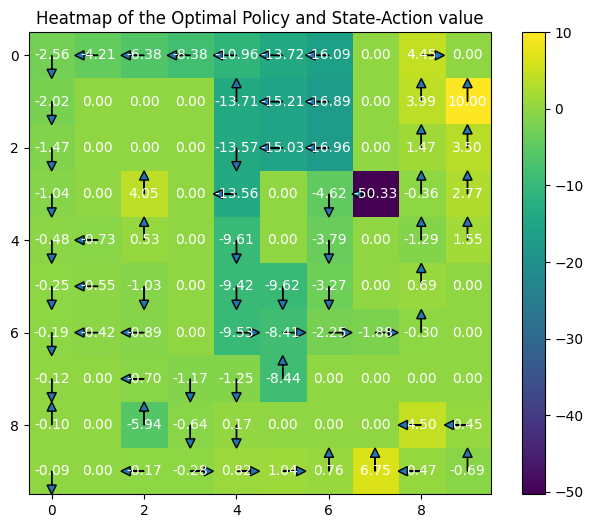

In [145]:
sarsa_111helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Method_softmax_Alpha_1.0_Gamma_1.0_Epsilon_None_Temp_1

The Best hyperparameters for this config is as follows:
- α = 1.0: all new information is incorporated into the estimates and therefore newer information have a greater impact on the Q-values i.e. the agent quickly adapts its policy based on the most recent experiences.

- γ = 1.0: signifies that the agent places equal importance on immediate and future rewards i.e. the agent considers future rewards to be as important as immediate rewards and places full emphasis on maximizing cumulative rewards over the entire trajectory.

- τ = 1: A higher temperature value like 1 indicates that the agent prefers a more diversified exploration potentially leading to discovering more diverse and potentially better policies.

The agent learns a policy that converges to the goal state (9,0). Looking at actions from state (6,3), we see that the agent has learned the optimal policy.


2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The difference in this config vs config 110 is the action selection method

- Unlike config 110 which used epsilon-greedy, config 111 converged much more quickly as it used softmax. This is evident in both the episodes vs rewards curve and the steps vs episodes curve. The curve is smother and converged in 1/3rd the number of episodes

- Softmax allows the agent to consider not just the best action according to its Q-values but also gives non-optimal actions a chance to be selected. This exploration can be useful in discovering new paths that might lead to better outcomes, especially when the wind creates uncertainty in the movement of the agent.

- Epsilon Greedy method in config 110 does not give as much weight to other non-greedy actions as softmax does, potentially causing the agent to miss alternative paths due to the wind.

The difference between this config and config 011 is the presence of wind

- In config 011, we can see in the state-visit heatmap that by the 50th episode, the average reward was approx -2 where as it is approx -8 for this config. This is because the wind takes the agent one state to the right than what it intended to go to. Thus it might take more steps for the agent to reach the goal state

- This is evident from the average steps vs episodes curve. By the 50th episode config 011 was taking approx 12 steps which is the optimal number of steps whereas this config took approx 14 steps. The additional 2 steps plus the wind causing the agent to move to the right where a bad state is also present can explain the stark difference in average reward.

### (5) Configuration id SARSA_101


#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# @title SARSA: (1, 0, 1) = (True, [0,4], softmax)
np.random.seed(3939)
random.seed(3939)

params_101 = param_generator('101', True)
print(f'Evaluating config {params_101} \n')
sarsa_101 = SARSAExp(**params_101)


hyperparams_101 = hyperparam_generator(sarsa_101, epsilon=False)


with Pool(processes=8) as p:
  results_101 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_101):
      results_101.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_101:
      sarsa_101.configs[config_name] = config
      sarsa_101.state_visits[config_name] = state_visits
      sarsa_101.Q[config_name] = Q
      sarsa_101.rewards[config_name] = avg_rewards_per_episode
      sarsa_101.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': True, 'start_state': [0, 4], 'strat': 'softmax'} 



100%|██████████| 64/64 [4:54:59<00:00, 276.55s/it]


In [ ]:
sarsa_101helper = SARSAExpHelper(sarsa_101)

print('\n')
print(sarsa_101helper.best_config())



Method_softmax_Alpha_1.0_Gamma_1.0_Epsilon_None_Temp_0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_101helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_101helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_101helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

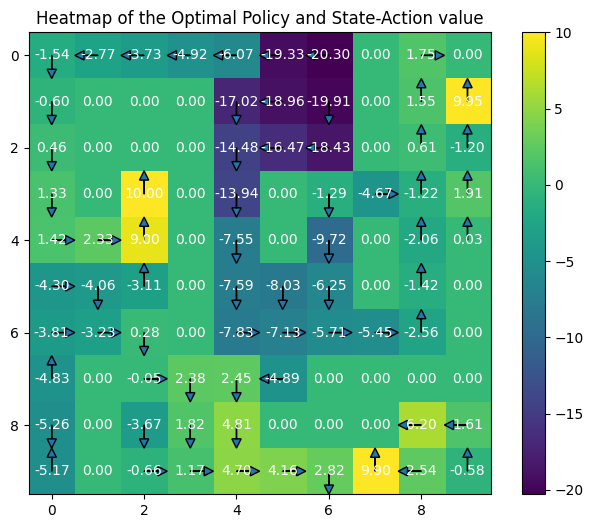

In [ ]:
sarsa_101helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.


The Best hyperparameters for this config is as follows:
- α = 1.0:  all new information is incorporated into the estimates and therefore newer information have a greater impact on the Q-values i.e. the agent quickly adapts its policy based on the most recent experiences.

- γ = 1.0: signifies that the agent places equal importance on immediate and future rewards i.e. the agent considers future rewards to be as important as immediate rewards and places full emphasis on maximizing cumulative rewards over the entire trajectory.

- τ = 0.1: leads to more deterministic action selection, where the agent predominantly selects actions with higher Q-values. This reduces exploration and tends towards exploitation of the best-known actions.


The agent learns an optimal policy that converges to the goal state (2,2).


2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The difference in this config vs config 111 is the start state.

- Similar to config 111, we see that the agent clearly prefers one goal state whose path runs along the edge or blocked states. Almost all of the trajectories ended in the goal state (2,2) which is evident in the state-visit heatmap. This could also be due to τ=0.1 which encourages exploitation instead of exploration.

- It however did take longer to converge which can be seen in the rewards vs episodes curve and the steps vs episodes curve.


The difference between this config and config 001 is Wind.

- In config 001, when wind is not present, the the agent explores many different paths which we can see on the state visit heatmap. Howeve for this config with wind, it has made a clear preference to a particular trajectory. This could be because the path to (2,2) runs along the edge causing the agent to stay in the same state in case of wind or take it to a previous state on the same path but not leading to a restart state or bad state.

- Config 001 also converged much quicker than this.

- The presence of wind has caused the agent to pretty much abandon exploration and instead emphasize exploitation of known strategies

### (4) Configuration id SARSA_100


#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
# @title SARSA: (1, 0, 0) = (True, [0,4], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

params_100 = param_generator('100', True)
print(f'Evaluating config {params_100} \n')
sarsa_100 = SARSAExp(**params_100)


hyperparams_100 = hyperparam_generator(sarsa_100, epsilon=True)


with Pool(processes=8) as p:
  results_100 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_experiment, hyperparams_100):
      results_100.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in results_100:
      sarsa_100.configs[config_name] = config
      sarsa_100.state_visits[config_name] = state_visits
      sarsa_100.Q[config_name] = Q
      sarsa_100.rewards[config_name] = avg_rewards_per_episode
      sarsa_100.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': True, 'start_state': [0, 4], 'strat': 'eps'} 



100%|██████████| 64/64 [1:40:48<00:00, 94.50s/it]


In [ ]:
sarsa_100helper = SARSAExpHelper(sarsa_100)

print('\n')
print(sarsa_100helper.best_config())



Method_eps_Alpha_1.0_Gamma_0.9_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
sarsa_100helper.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
sarsa_100helper.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
sarsa_100helper.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

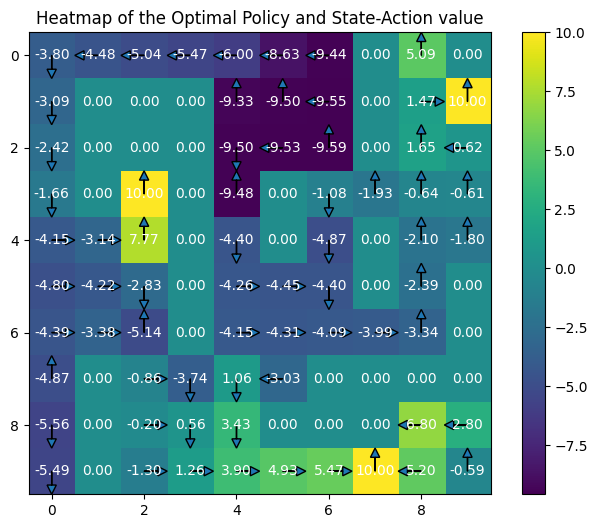

In [ ]:
sarsa_100helper.plot_policy_q_heatmap()

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.


The Best hyperparameters for this config is as follows:
- α = 1.0:  all new information is incorporated into the estimates and therefore newer information have a greater impact on the Q-values i.e. the agent quickly adapts its policy based on the most recent experiences.

- γ = 0.9: signifies that the agent places almost equal importance on immediate and future rewards i.e. the agent considers future rewards to be nearly as important as immediate rewards and places a large emphasis on maximizing cumulative rewards over the entire trajectory.

- ϵ = 0.001: the agent predominantly exploits the best known actions based on the greedy policy.

The agent learns an optimal policy that converges to the goal state (2,2)

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

The  difference in this config vs config 101 is the action selection method.

- From the average rewards vs episodes curves of the two configs we can see that the softmax config converged to an average reward value of approx -8 whereas this config with epsilon-greedy converged to approx -10.

- From the average steps vs episodes curves of the two configs we can see that the softmax config converged to an average steps of approx 15 whereas this config with epsilon-greedy converged to approx 18.

- Softmax action selection clearly performed better

- However the lower part of the grid world was visited more using epsilon-greedy than softmax. With softmax, a particular trajectory was followed for the most part. With epsilon-greedy there is a bit more exploration.

The difference between this config and config 000 is the wind

- When wind was not present the agent explored three different trajectories. All three goal states were significantly explored

- However when the wind is present, primarily the goal state (2,2) which runs along the edges was preffered.

- When we look at the rewards vs episodes curve and the steps vs episodes curve for both the configs, we see that the one without wind had more oscillations.



## QLearning

### (0) Configuration id QLearn_000

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

In [ ]:
# @title QLearning: (0, 0, 0) = (1, [0,4], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

Qparams_000 = param_generator('000', False)
print(f'Evaluating config {Qparams_000} \n')
qlearn_000 = QLearning(**Qparams_000)


Qhyperparams_000 = hyperparam_generator(qlearn_000, epsilon=True)


with Pool(processes=8) as p:
  Qresults_000 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_000):
      Qresults_000.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_000:
      qlearn_000.configs[config_name] = config
      qlearn_000.state_visits[config_name] = state_visits
      qlearn_000.Q[config_name] = Q
      qlearn_000.rewards[config_name] = avg_rewards_per_episode
      qlearn_000.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': False, 'start_state': [0, 4], 'strat': 'eps'} 



100%|██████████| 64/64 [1:35:04<00:00, 89.13s/it]


In [84]:
qlhelper_000 = QLearningHelper(qlearn_000)
print(qlhelper_000.best_config())

Method_eps_Alpha_1.0_Gamma_0.7_Epsilon_0.01_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [85]:
qlhelper_000.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [86]:
qlhelper_000.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [88]:
qlhelper_000.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

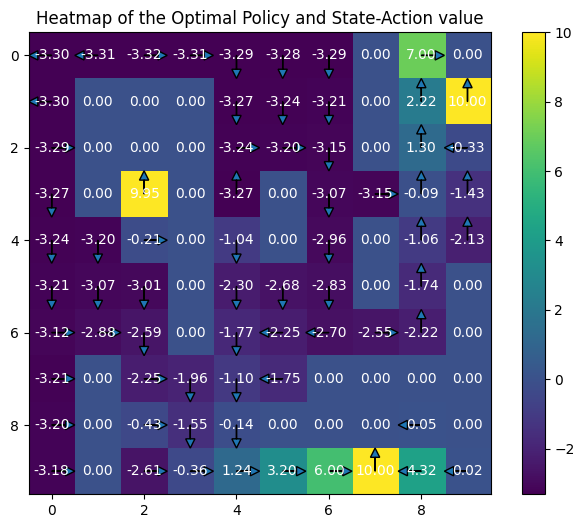

In [89]:
qlhelper_000.plot_policy_q_heatmap()

### (1) Configuration id QLearn_001

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
# @title QLearning: (0, 0, 1) = (1, [0,4], softmax)
np.random.seed(3939)
random.seed(3939)

Qparams_001 = param_generator('001', False)
print(f'Evaluating config {Qparams_001} \n')
qlearn_001 = QLearning(**Qparams_001)


Qhyperparams_001 = hyperparam_generator(qlearn_001, epsilon=False)


with Pool(processes=8) as p:
  Qresults_001 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_001):
      Qresults_001.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_001:
      qlearn_001.configs[config_name] = config
      qlearn_001.state_visits[config_name] = state_visits
      qlearn_001.Q[config_name] = Q
      qlearn_001.rewards[config_name] = avg_rewards_per_episode
      qlearn_001.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': False, 'start_state': [0, 4], 'strat': 'softmax'} 



100%|██████████| 64/64 [4:24:29<00:00, 247.96s/it]


In [90]:
qlhelper_001 = QLearningHelper(qlearn_001)
print(qlhelper_001.best_config())

Method_softmax_Alpha_1.0_Gamma_0.9_Epsilon_None_Temp_0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [97]:
qlhelper_001.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [98]:
qlhelper_001.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [99]:
qlhelper_001.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

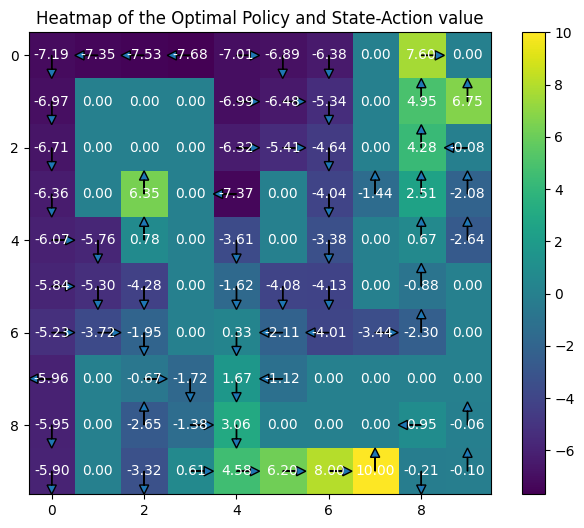

In [100]:
qlhelper_001.plot_policy_q_heatmap()

### (2) Configuration id QLearn_010

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

In [ ]:
# @title QLearning: (0, 1, 0) = (1, [3,6], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

Qparams_010 = param_generator('010', False)
print(f'Evaluating config {Qparams_010} \n')
qlearn_010 = QLearning(**Qparams_010)


Qhyperparams_010 = hyperparam_generator(qlearn_010, epsilon=True)


with Pool(processes=8) as p:
  Qresults_010 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_010):
      Qresults_010.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_010:
      qlearn_010.configs[config_name] = config
      qlearn_010.state_visits[config_name] = state_visits
      qlearn_010.Q[config_name] = Q
      qlearn_010.rewards[config_name] = avg_rewards_per_episode
      qlearn_010.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': False, 'start_state': [3, 6], 'strat': 'eps'} 



100%|██████████| 64/64 [1:27:32<00:00, 82.07s/it]


In [91]:
qlhelper_010 = QLearningHelper(qlearn_010)
print(qlhelper_010.best_config())

Method_eps_Alpha_1.0_Gamma_0.7_Epsilon_0.01_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [101]:
qlhelper_010.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [102]:
qlhelper_010.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.


In [104]:
qlhelper_010.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

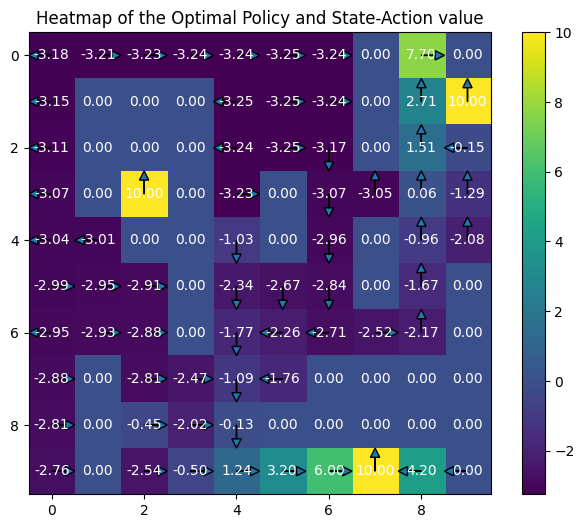

In [106]:
qlhelper_010.plot_policy_q_heatmap()

### (3) Configuration id QLearn_011

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
# @title QLearning: (0, 1, 1) = (1, [3,6], softmax)
np.random.seed(3939)
random.seed(3939)

Qparams_011 = param_generator('011', False)
print(f'Evaluating config {Qparams_011} \n')
qlearn_011 = QLearning(**Qparams_011)


Qhyperparams_011 = hyperparam_generator(qlearn_011, epsilon=False)


with Pool(processes=8) as p:
  Qresults_011 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_011):
      Qresults_011.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_011:
      qlearn_011.configs[config_name] = config
      qlearn_011.state_visits[config_name] = state_visits
      qlearn_011.Q[config_name] = Q
      qlearn_011.rewards[config_name] = avg_rewards_per_episode
      qlearn_011.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 1, 'wind': False, 'start_state': [3, 6], 'strat': 'softmax'} 



100%|██████████| 64/64 [3:56:56<00:00, 222.13s/it]


In [92]:
qlhelper_011 = QLearningHelper(qlearn_011)
print(qlhelper_011.best_config())

Method_softmax_Alpha_1.0_Gamma_0.8_Epsilon_None_Temp_0.1


1. Plot reward curves (during the training phase with the best hyperparameters).

In [107]:
qlhelper_011.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [108]:
qlhelper_011.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [110]:
qlhelper_011.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

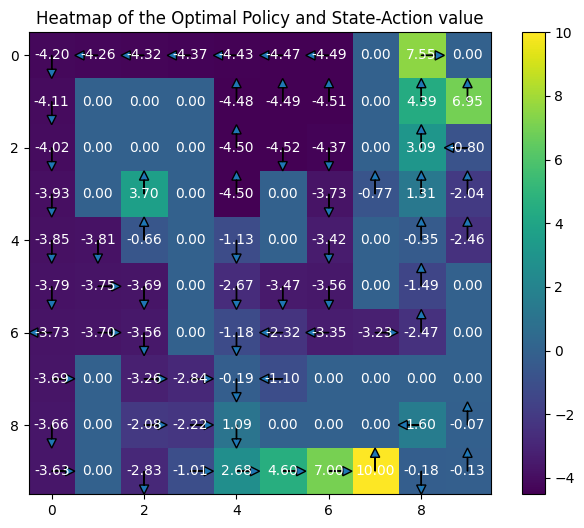

In [111]:
qlhelper_011.plot_policy_q_heatmap()

### (4) Configuration id QLearn_100

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

In [ ]:
# @title QLearning: (1, 0, 0) = (0.7, [0,4], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

Qparams_100 = param_generator('100', False)
print(f'Evaluating config {Qparams_100} \n')
qlearn_100 = QLearning(**Qparams_100)


Qhyperparams_100 = hyperparam_generator(qlearn_100, epsilon=True)


with Pool(processes=8) as p:
  Qresults_100 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_100):
      Qresults_100.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_100:
      qlearn_100.configs[config_name] = config
      qlearn_100.state_visits[config_name] = state_visits
      qlearn_100.Q[config_name] = Q
      qlearn_100.rewards[config_name] = avg_rewards_per_episode
      qlearn_100.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 0.7, 'wind': False, 'start_state': [0, 4], 'strat': 'eps'} 



100%|██████████| 64/64 [2:10:50<00:00, 122.66s/it]


In [93]:
qlhelper_100 = QLearningHelper(qlearn_100)
print(qlhelper_100.best_config())

Method_eps_Alpha_0.1_Gamma_1.0_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [112]:
qlhelper_100.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [113]:
qlhelper_100.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [114]:
qlhelper_100.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

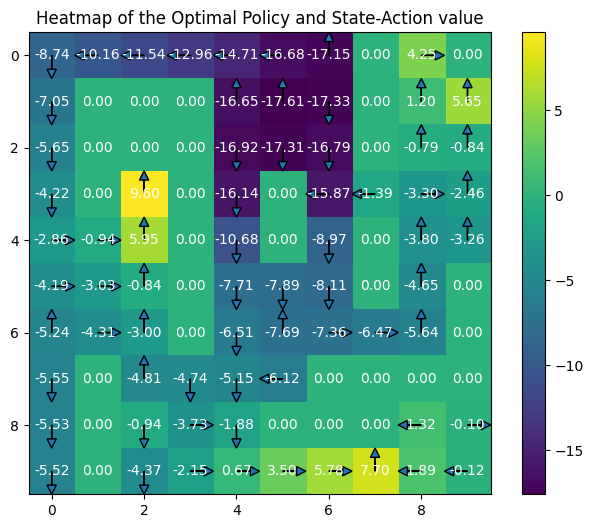

In [115]:
qlhelper_100.plot_policy_q_heatmap()

### (5) Configuration id QLearn_101

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = Softmax

In [ ]:
# @title QLearning: (1, 0, 1) = (0.7, [0,4], Softmax)
np.random.seed(3939)
random.seed(3939)

Qparams_101 = param_generator('101', False)
print(f'Evaluating config {Qparams_101} \n')
qlearn_101 = QLearning(**Qparams_101)


Qhyperparams_101 = hyperparam_generator(qlearn_101, epsilon=False)


with Pool(processes=8) as p:
  Qresults_101 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_101):
      Qresults_101.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_101:
      qlearn_101.configs[config_name] = config
      qlearn_101.state_visits[config_name] = state_visits
      qlearn_101.Q[config_name] = Q
      qlearn_101.rewards[config_name] = avg_rewards_per_episode
      qlearn_101.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 0.7, 'wind': False, 'start_state': [0, 4], 'strat': 'softmax'} 



100%|██████████| 64/64 [5:29:01<00:00, 308.47s/it]


In [94]:
qlhelper_101 = QLearningHelper(qlearn_101)
print(qlhelper_101.best_config())

Method_softmax_Alpha_0.1_Gamma_1.0_Epsilon_None_Temp_0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

In [116]:
qlhelper_101.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [117]:
qlhelper_101.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [118]:
qlhelper_101.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

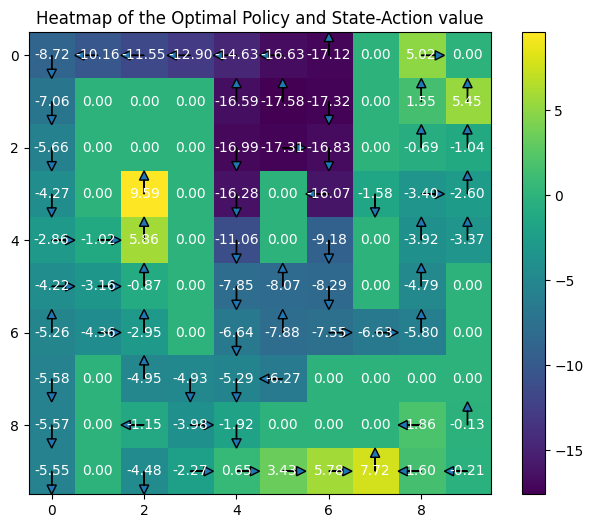

In [119]:
qlhelper_101.plot_policy_q_heatmap()

### (6) Configuration id QLearn_110

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

In [80]:
# @title QLearning: (1, 1, 0) = (0.7, [3,6], epsilon-greedy)
np.random.seed(3939)
random.seed(3939)

Qparams_110 = param_generator('110', False)
print(f'Evaluating config {Qparams_110} \n')
qlearn_110 = QLearning(**Qparams_110)


Qhyperparams_110 = hyperparam_generator(qlearn_110, epsilon=True)


with Pool(processes=8) as p:
  Qresults_110 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_110):
      Qresults_110.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_110:
      qlearn_110.configs[config_name] = config
      qlearn_110.state_visits[config_name] = state_visits
      qlearn_110.Q[config_name] = Q
      qlearn_110.rewards[config_name] = avg_rewards_per_episode
      qlearn_110.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 0.7, 'wind': False, 'start_state': [3, 6], 'strat': 'eps'} 



100%|██████████| 64/64 [2:12:32<00:00, 124.26s/it]


In [95]:
qlhelper_110 = QLearningHelper(qlearn_110)
print(qlhelper_110.best_config())

Method_eps_Alpha_0.1_Gamma_1.0_Epsilon_0.001_Temp_None


1. Plot reward curves (during the training phase with the best hyperparameters).

In [120]:
qlhelper_110.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [121]:
qlhelper_110.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [122]:
qlhelper_110.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

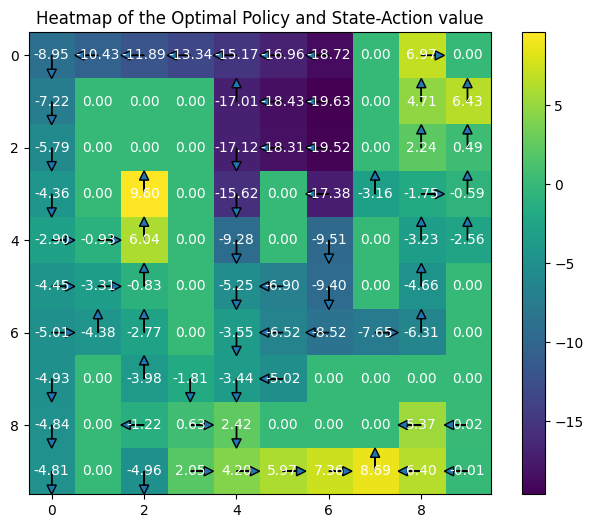

In [123]:
qlhelper_110.plot_policy_q_heatmap()

### (7) Configuration id QLearn_111

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = Softmax

In [81]:
# @title QLearning: (1, 1, 1) = (0.7, [3,], Softmax)
np.random.seed(3939)
random.seed(3939)

Qparams_111 = param_generator('111', False)
print(f'Evaluating config {Qparams_111} \n')
qlearn_111 = QLearning(**Qparams_111)


Qhyperparams_111 = hyperparam_generator(qlearn_111, epsilon=False)


with Pool(processes=8) as p:
  Qresults_111 = []
  with tqdm(total=64) as pbar:
    for result in p.imap_unordered(run_Qlearning, Qhyperparams_111):
      Qresults_111.append(result)
      pbar.update()

for config_name, config, state_visits, Q, avg_rewards_per_episode, avg_steps_per_episode in Qresults_111:
      qlearn_111.configs[config_name] = config
      qlearn_111.state_visits[config_name] = state_visits
      qlearn_111.Q[config_name] = Q
      qlearn_111.rewards[config_name] = avg_rewards_per_episode
      qlearn_111.steps[config_name] = avg_steps_per_episode

Evaluating config {'p': 0.7, 'wind': False, 'start_state': [3, 6], 'strat': 'softmax'} 



100%|██████████| 64/64 [5:30:28<00:00, 309.82s/it]


In [96]:
qlhelper_111 = QLearningHelper(qlearn_111)
print(qlhelper_111.best_config())

Method_softmax_Alpha_0.1_Gamma_1.0_Epsilon_None_Temp_0.01


1. Plot reward curves (during the training phase with the best hyperparameters).

In [124]:
qlhelper_111.plot_best_curve()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).


In [125]:
qlhelper_111.plot_best_steps()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [126]:
qlhelper_111.plot_state_visit_heatmap()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

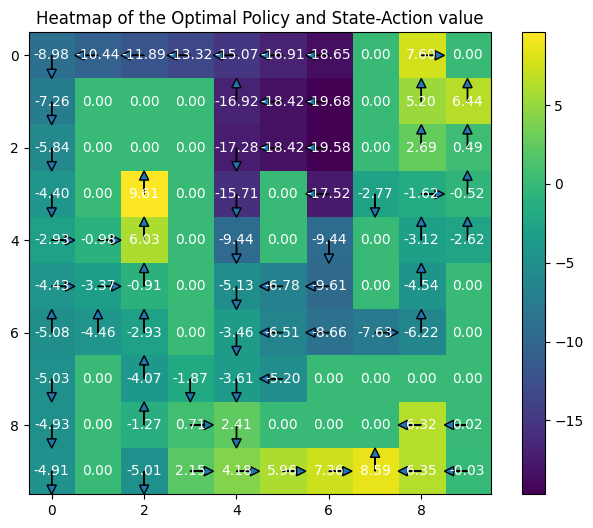

In [127]:
qlhelper_111.plot_policy_q_heatmap()

# SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [ ]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [ ]:
# Optional: any supplementary code

Optional Comments:

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [ ]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [ ]:
# Optional: any supplementary code

Optional Comments: